In [10]:
%matplotlib inline  

# NDVI  
<br>  
  
> **NDVI(Normalized Difference Vegetation Index**  
> A derived index that correlates well with the existance of vegetation.  

<br>

$$ NDVI =  \frac{(NIR - RED)}{(NIR + RED)}$$  

<br>

In [2]:
def NDVI(dataset):
    return (dataset.nir - dataset.red)/(dataset.nir + dataset.red)

<br>
# NDWI  
  
<br>
> ** NDWI Normalized Difference Water Index **  
> A derived index that correlates well with the existance of water.  
<br>

$$ NDWI =  \frac{GREEN - NIR}{GREEN + NIR}$$  
  
<br>

In [3]:
def NDWI(dataset):
    return (dataset.green - dataset.nir)/(dataset.green + dataset.nir)

<br>  

# NDBI  
<br>  
> ** NDWI Normalized Difference Build-Up Index **  
> A derived index that correlates well with the existance of urbanization.  
<br>

$$ NDBI =  \frac{(SWIR - NIR)}{(SWIR + NIR)}$$  
 
<br>  

In [4]:
def NDBI(dataset):
        return (dataset.swir2 - dataset.nir)/(dataset.swir2 + dataset.nir)

<br>
# MOSAIC  
  
<br>  
>** Recent-Pixel-First Mosaic **   
>A cloud free representation of satellite imagery. Works by masking out clouds from imagery, and using the most recent cloud-free pixels in an image.  

![](diagrams/urbanization/flat_mosaic.png)
  
<br>  

In [5]:
from utils.data_cube_utilities.dc_mosaic import create_mosaic

def mosaic(dataset):
    # The mask here is based on cf_mask. It comes bundled in with most Landsat Products.
    cloud_free_boolean_mask = dataset.cf_mask.values < 2
    return create_mosaic(dataset, clean_mask = cloud_free_boolean_mask)

<br>
  
> **Median Mosaic**  
>  A cloud free representation fo satellite imagery. Works by masking out clouds from imagery, and using the median valued cloud-free pixels in the time series  
  
<br>


![](diagrams/urbanization/median_comp.png)  
  
<br>

In [6]:
from utils.data_cube_utilities.dc_mosaic import create_median_mosaic

def median_mosaic(dataset):
    # The mask here is based on cf_mask. It comes bundled in with most Landsat Products.
    clean_mask = dataset.cf_mask.values < 2
    return create_median_mosaic(dataset, clean_mask = clean_mask)

<br>  

# Loading Data

> **Data cube object**  
> A datacube object is your interface with data stored on your data cube system.  
<br>  

In [7]:
import datacube  
dc = datacube.Datacube(app = '3B_urban', config = '/home/localuser/.datacube.conf')  

<br>

> **Loading a Dataset**  
> Requires latitude-longitude bounds of an area, a time-range, list of desired measurements, platform and product names.

In [8]:
from datetime import datetime

## Loading in a region of vietnam  
lat = (10.8381,11.3526 )
lon = (106.9136,107.5348)

## Considering the year of 2015
date_range = (
    datetime(2015,1,1),
    datetime(2015,12,24))

## Landsat 8 Data
platform = 'LANDSAT_8'

## "ls8_ledaps_vietnam" is a key used to load data with certain types of projections and geographic spans.  
product = 'ls8_ledaps_vietnam'

desired_bands = ['red','green','nir','swir2', 'cf_mask']  # needed by ndvi, ndwi, ndbi and cloud masking
desired_bands = desired_bands + ['blue'] # blue is needed for a true color visualization purposes

landsat_dataset = dc.load(product = product,\
	platform = platform,\
	lat = lat,\
	lon = lon,\
	time = date_range,\
	measurements = desired_bands)


<br>  

# Displaying Data  
<br>  

>**A cloud free composite**  
Clouds get in the way of understanding the area. Cloud free composites draw from a history of acquisitions to generate a cloud free representation of your area  

<br>  

In [9]:
landsat_mosaic = median_mosaic(landsat_dataset)

AttributeError: 'Dataset' object has no attribute 'cf_mask'

<br>  
> **Saving your data**  
> A .tiff or png is a great way to represent true color mosaics. The image below is a saved .png representation of of a landsat mosaic.  

In [11]:
from utils.data_cube_utilities.dc_utilities import write_png_from_xr
write_png_from_xr('diagrams/urbanization/cloud_free_mosaic.png', landsat_mosaic, ["red", "green", "blue"], scale = [(0,2000),(0,2000),(0,2000)])

<br>  

![](diagrams/urbanization/cloud_free_mosaic.png)  
  
<br>  

<br>
# Urbanization Analysis  
<br>  

> **NDWI, NDVI, NDBI**  
You will very rarely have urban classification and water classifications apply to the same pixel. For urban analysis, it may make sense to compute not just urban classes, but classes that are unlikely to co-occur with urbanization. 
  
<br>

In [12]:
ndbi = NDBI(landsat_mosaic)  # Urbanization
ndvi = NDVI(landsat_mosaic)  # Dense Vegetation
ndwi = NDWI(landsat_mosaic)  # High Concentrations of Water

<br>
<br>
>**Plot Values**  
> xarray data-arrays have built in plotting functions you can use to validate trends or differences in your data.  
<br>
  

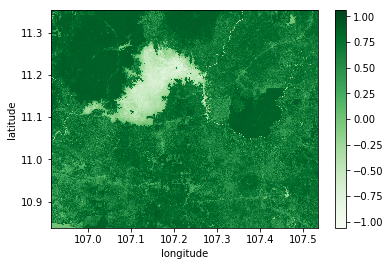

In [13]:
(ndvi).plot(cmap = "Greens")

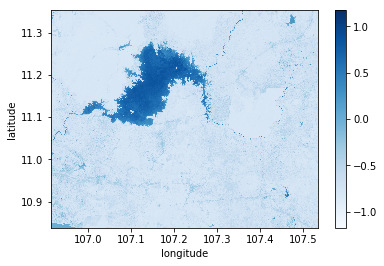

In [14]:
(ndwi).plot(cmap = "Blues")

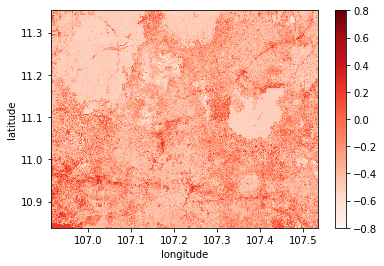

In [15]:
(ndbi + 0.2).plot(cmap = "Reds")

> **Convert To a Dataset**  
It's good practice to accurately name your datasets and data-arrays. If you'd like to merge data-arrays into a larger datasets, you should convert data-arrays to datasets

In [17]:
ds_ndvi = ndvi.to_dataset(name = "NDVI")
ds_ndwi = ndwi.to_dataset(name=  "NDWI")
ds_ndbi = ndbi.to_dataset(name = "NDBI")

<br>
> **Merge into one large Dataset **  
> If your data-arrays share the same set of coordinates, or if you feel that you'll be using these values together in the future,  you should consider merging them into a dataset

In [18]:
urbanization_dataset = ds_ndvi.merge(ds_ndwi).merge(ds_ndbi)

<br>  
>** Checking your Merge **  
>The string readout of your new dataset should give you a good idea about how the `.merge` went.  
<br>

In [19]:
print(urbanization_dataset)

<xarray.Dataset>
Dimensions:    (latitude: 1910, longitude: 2306)
Coordinates:
  * latitude   (latitude) float64 11.35 11.35 11.35 11.35 11.35 11.35 11.35 ...
  * longitude  (longitude) float64 106.9 106.9 106.9 106.9 106.9 106.9 106.9 ...
Data variables:
    NDVI       (latitude, longitude) float64 0.8629 0.7608 0.7084 0.7016 ...
    NDWI       (latitude, longitude) float64 -0.7709 -0.7303 -0.7092 -0.7028 ...
    NDBI       (latitude, longitude) float64 -0.6212 -0.4992 -0.4382 -0.402 ...


<br>  
<br>  

>**Building a False Color Composite**  
> If you have three lowly correlated measurements, place each measurement on its own Red, Green, Blue channel and visualize it. 

In [23]:
write_png_from_xr('diagrams/urbanization/false_color.png', urbanization_dataset, ["NDBI", "NDVI", "NDWI"], scale = [(-1,1),(0,1),(0,1)])

![](diagrams/urbanization/false_color.png)

<br>
>**Analyze The False Color Image**  

> Values that adhere strongly to individual classes adhere to their own color channel. In this example, NDVI adheres to green, NDWI adheres to blue, and NDBI seems to adhere to red  

<br>  
<br>  
> **Validate urbanization using other imagery**  
> Double check results using high-resolution imagery.  Compare to the false color mosaic
<br>

In [26]:
from utils.data_cube_utilities.dc_display_map import display_map
display_map(latitude = lat ,longitude = lon)  